In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('/u/ajagadish/vanilla-llama/categorisation/')
sys.path.append('/u/ajagadish/vanilla-llama/categorisation/data')
sys.path.append('/u/ajagadish/vanilla-llama/categorisation/rl2')
import torch
import torch.nn.utils.rnn as rnn_utils
import numpy as np

In [6]:
datas = pd.read_csv('../data/llm/badham2017deficits_usinghumanchoicehistory.csv')

/u/ajagadish/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
categories = {'j': 'A', 'f': 'B'}
datas['human_category']=datas['choice'].map(categories)

In [8]:
datas

,participant,task,trial,choice,correct_choice,reward,block,condition,category,object,all_features,feature1,feature2,feature3,llm_category,true_category,human_category
0,0,0,0,j,j,1.0,0,1,1,Big Black Square,"[1, 1, 1]",1,1,1,A,A,A
1,0,0,1,j,f,-1.0,0,1,0,Small Black Triangle,"[0, 1, 0]",0,1,0,B,B,A
2,0,0,2,f,j,-1.0,0,1,1,Big White Triangle,"[1, 0, 0]",1,0,0,A,A,B
3,0,0,3,f,f,1.0,0,1,0,Small White Triangle,"[0, 0, 0]",0,0,0,B,B,B
4,0,0,4,f,f,1.0,0,1,0,Small White Square,"[0, 0, 1]",0,0,1,B,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33435,94,0,331,f,f,1.0,3,1,0,Big White Triangle,"[1, 0, 0]",1,0,0,NaN,NaN,B
33436,94,0,332,j,j,1.0,3,1,1,Small Black Triangle,"[0, 1, 0]",0,1,0,NaN,NaN,A
33437,94,0,333,j,j,1.0,3,1,1,Small Black Square,"[0, 1, 1]",0,1,1,NaN,NaN,A
33438,94,0,334,f,f,1.0,3,1,0,Small White Triangle,"[0, 0, 0]",0,0,0,NaN,NaN,B


In [9]:
datas[datas.participant==66][datas.block==3]

/tmp/ipykernel_110967/1803320314.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  datas[datas.participant==66][datas.block==3]


,participant,task,trial,choice,correct_choice,reward,block,condition,category,object,all_features,feature1,feature2,feature3,llm_category,true_category,human_category
23312,66,0,240,f,f,1.0,3,3,0,Small White Triangle,"[0, 0, 0]",0,0,0,NaN,NaN,B
23313,66,0,241,j,j,1.0,3,3,1,Big Black Triangle,"[1, 1, 0]",1,1,0,NaN,NaN,A
23314,66,0,242,f,f,1.0,3,3,0,Small Black Square,"[0, 1, 1]",0,1,1,NaN,NaN,B
23315,66,0,243,f,j,-1.0,3,3,1,Small Black Triangle,"[0, 1, 0]",0,1,0,NaN,NaN,B
23316,66,0,244,j,f,-1.0,3,3,0,Big White Triangle,"[1, 0, 0]",1,0,0,NaN,NaN,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23403,66,0,331,j,j,1.0,3,3,1,Small Black Triangle,"[0, 1, 0]",0,1,0,NaN,NaN,A
23404,66,0,332,f,f,1.0,3,3,0,Big White Triangle,"[1, 0, 0]",1,0,0,NaN,NaN,B
23405,66,0,333,f,f,1.0,3,3,0,Small White Square,"[0, 0, 1]",0,0,1,NaN,NaN,B
23406,66,0,334,j,f,-1.0,3,3,0,Small Black Square,"[0, 1, 1]",0,1,1,NaN,NaN,A


In [10]:
num_participants = 46
correct = np.ones((4, num_participants, 96))
human_correct = np.ones((4, num_participants, 96))

for participant_id  in range(num_participants):#= 4
    for cond in datas.condition.unique(): #datas.condition.nunique()):
        data = datas[datas.condition==cond]
        correct_trials = data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values
        correct[cond-1, participant_id,:len(correct_trials)] = correct_trials
        
        human_correct_trials = data[data.participant==participant_id].human_category.values==data[data.participant==participant_id].true_category.values
        human_correct[cond-1, participant_id,:len(correct_trials)] = human_correct_trials
        #plt.plot(data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values)

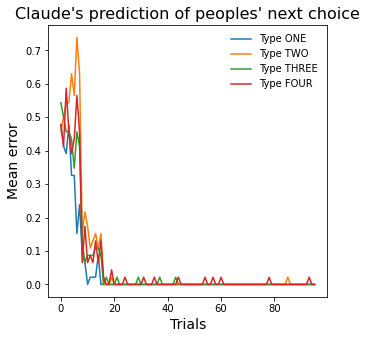

In [11]:
plt.figure(figsize=(5,5))
for cond in range(datas.condition.nunique()):
    plt.plot(1-correct[cond].mean(0), label = ["Type ONE", "Type TWO", "Type THREE", "Type FOUR"][cond])
plt.title("Claude's prediction of peoples' next choice", fontsize=16)
plt.xlabel("Trials", fontsize=14)
plt.ylabel("Mean error", fontsize=14)
plt.legend(frameon=False)#, fontsize=14)
plt.show()

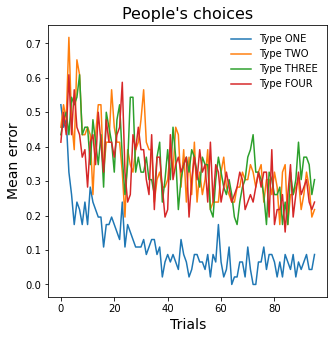

In [12]:
plt.figure(figsize=(5,5))
for cond in range(datas.condition.nunique()):
    plt.plot(1-human_correct[cond].mean(0), label = ["Type ONE", "Type TWO", "Type THREE", "Type FOUR"][cond])
plt.title("People's choices", fontsize=16)
plt.xlabel("Trials", fontsize=14)
plt.ylabel("Mean error", fontsize=14)
plt.legend(frameon=False)#, fontsize=14)
plt.show()